# Анализ программы лояльности

## Оглавление:
* [1. Введение. Цель проекта](#1-bullet)


* [2. Предобработка данных](#2-bullet)
    * [2.1 Загрузка данных](#2.1-bullet)
    * [2.2 Обработка дубликатов](#2.2-bullet)
    * [2.3 Обработка пропущенных и отрицательных значений](#2.3-bullet)
    * [2.4 Изменение типов данных](#2.4-bullet)
    * [2.5 Вывод по разделу](#2.5-bullet)
    

* [3. Исследовательский анализ данных](#3-bullet)
    * [3.1 Объединение данных о покупках и стоимости товаров](#3.1-bullet)
    * [3.2 Группировка данных по клиентам, магазинам и товарам](#3.2-bullet)
    * [3.3 Оценка распределений и корреляций](#3.3-bullet)
    * [3.4 Обработка аномальных значений](#3.4-bullet)
   
   
* [4. Анализ программы лояльности](#4-bullet)
    * [4.1 Оценка выручки по группам клиентов](#4.1-bullet)
    * [4.2 Оценка среднего чека по группам клиентов](#4.2-bullet)
    * [4.3 Оценка количества покупок по группам клиентов](#4.3-bullet)
    * [4.4 Расчёт показателей статистической значимости и проверка гипотез](#4.4-bullet)
        * [4.4.1 Средний чек](#4.4.2-bullet)
        * [4.4.2 Количество покупок](#4.4.3-bullet)
     * [4.5 TOP-5 товаров каждой клиентской группы](#4.5-bullet)
     * [4.6 Распределение выручки между  магазинами ](#4.6-bullet)
 
 
* [5. Выводы и рекомендации](#5-bullet)


* [6. Приложения: презентация](https://drive.google.com/file/d/1l8jJhymtqm1ar_mFW_sJaZ6g77H72IYq/view?usp=sharing)

## 1. Введение. Цель проекта<a class="anchor" id="1-bullet"></a>

Исследование проводится для ответа на вопрос эффективности программы лояльности магазина строительных материалов «Строили, строили и наконец построили». 

Все покупатели могут получить доступ в магазин с использованием персональных карт и за 200 рублей в месяц  могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.

Метриками эффективности определены:
- выручка;
- средний чек;
- количество покупок.

Будет проведён сравнительный анализ данных метрик между клиентами, не участвующими в программе лояльности (группа А) и клиентами - участниками программы (группа В).

## 2. Предобработка данных<a class="anchor" id="2-bullet"></a>

###  2.1 Загрузка данных<a class="anchor" id="2.1-bullet"></a>

In [1]:
# для анализа будут использоваться python - библиотеки: Pandas, Matplotlib, NumPy, Datetime, Scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
import numpy as np
import datetime as dt
import scipy.stats as stats

# вывод предупреждений подавлен
import warnings
warnings.filterwarnings("ignore")

In [2]:
# предустановка общих параметров графиков
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
# импорт файлов
pur = pd.read_csv('/datasets/retail_dataset.csv')
cod = pd.read_csv('/datasets/product_codes.csv')

In [4]:
#функция агрегирования нужной информации о датасете. Реализовано с целью улучшения визуализации информации.
def intro_df(df_name):

    entries_count = pd.DataFrame(df_name.nunique())
    entries_count.columns = ['values_counts']

    columns_types = pd.DataFrame(df_name.dtypes)
    columns_types.columns = ['dtypes']
    
    entries_count_isnull = pd.DataFrame(df_name.isnull().sum())
    entries_count_isnull.columns = ['isnull_counts']
    
    
    entries_max = pd.DataFrame(df_name.max())
    entries_max.columns = ['max']
    
    
    entries_min = pd.DataFrame(df_name.min())
    entries_min.columns = ['min']
    
    df_name_intro_info = entries_count.join(columns_types)\
                                      .join(entries_count_isnull)\
                                      .join(entries_max)\
                                      .join(entries_min)
    
    df_name.columns = df_name.columns.str.lower().str.replace(' ','_')

    print('Параметры таблицы , (строк, полей):', df_name.shape)
    print('Количество дубликатов:', df_name.duplicated().sum())
    display(df_name_intro_info.transpose())
    print('Первые 3 строки таблицы:')
    display(df_name.head(3))

Файл retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

In [5]:
intro_df(pur)

Параметры таблицы , (строк, полей): (105335, 7)
Количество дубликатов: 1033


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
values_counts,4894,3159,301,4430,1749,31,2
dtypes,object,object,int64,object,float64,object,float64
isnull_counts,0,0,0,0,36210,0,0
max,C545189,m,74214,2017-02-28 17:04:00,23962,Shop 9,1
min,536365,10002,-74216,2016-12-01 08:26:00,18025,Shop 0,0


Первые 3 строки таблицы:


,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0


Файл product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара.

In [6]:
intro_df(cod)

Параметры таблицы , (строк, полей): (9969, 2)
Количество дубликатов: 0


,productID,price_per_one
values_counts,3159,586
dtypes,object,float64
isnull_counts,0,0
max,m,16888
min,10002,0


Первые 3 строки таблицы:


,productid,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75


Загрузка данных успешно проведена. Выявленные аномалии:
- информация о датах представлена типом данных 'object';
- в количестве покупок имеются нулевые и отрицательные значения;
- имеются 36210 пропущенных значений id покупателя;
- количество значений id товара меньше, чем количество строк, т.е. одинаковые товары занесены в БД с разными ценами.


### 2.2 Изменение типов данных<a class="anchor" id="2.2-bullet"></a>

In [7]:
pur['purchasedate'] = pd.to_datetime(pur['purchasedate']).dt.round("D")
pur['purchasedate'][0:1]

0   2016-12-11
Name: purchasedate, dtype: datetime64[ns]

Поле со временем совершения покупок успешно преобразовано во временной формат с округлением до дня.

In [8]:
pur['loyalty_program'] = pur['loyalty_program'].astype('int64')

### 2.3 Обработка дубликатов<a class="anchor" id="2.3-bullet"></a>

Учитывая их незначительное количество, дубликаты будут удалены.

In [9]:
pur.drop_duplicates().shape

(104301, 7)

Дубликаты успешно удалены. Оставшееся количество строк для анализа - 104301.

### 2.4 Обработка пропущенных и отрицательных значений<a class="anchor" id="2.4-bullet"></a>

Пропущенные значения поля "customerid" указывают на покупки, совершённые оптовыми клиентами, которые находятся вне интересов исследования и которые могут быть удалены.

Отрицательные значения поля "quantity" являются возвратами и эти строки могут быть удалены.

Значения поля "quantity" равные нулю являются следствием технической ошибки и подлежат удалению, т.к. их заполнение .

Формирование очищенного датасета:

In [10]:
pur = pur[~pur['customerid'].isnull()]
pur = pur[pur['quantity'] > 0]

### 2.4 Изменение типов данных<a class="anchor" id="2.4-bullet"></a>

In [11]:
pur['purchasedate'] = pd.to_datetime(pur['purchasedate']).dt.round("D")
pur[['customerid','loyalty_program', 'purchaseid']] = pur[['customerid','loyalty_program', 'purchaseid']]\
                                       .astype('int64')

Преобразование типов данных успешно проведено.

### 2.5 Вывод по разделу<a class="anchor" id="2.5-bullet"></a>

In [12]:
intro_df(pur)

Параметры таблицы , (строк, полей): (54168, 7)
Количество дубликатов: 284


,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program
values_counts,3329,2579,148,81,1671,29,2
dtypes,int64,object,int64,datetime64[ns],int64,object,int64
isnull_counts,0,0,0,0,0,0,0
max,545218,POST,74214,2017-03-01 00:00:00,23962,Shop 9,1
min,536365,10002,1,2016-12-01 00:00:00,18025,Shop 0,0


Первые 3 строки таблицы:


,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program
0,538280,21873,11,2016-12-11,18427,Shop 0,0
2,538855,21239,7,2016-12-15,22182,Shop 0,1
10,537795,82494L,5,2016-12-09,22892,Shop 0,1


После валидации исходных можно выделить следующие особенности данных к дальнейшей обработке:
- количичество строк уменьшилось на 49%, с 105 тыс. до 54 тыс. строк;
- количество чеков уменьшилось на 32%, с 4,9 тыс. до 3,3 тыс. чеков;
- количество уникальных покупателей на 6%, с 1,7 тыс. до 1,6 тыс. покупателей.

Таким образом, удаление выбивающихся из логики исследования данных позволило оставить репрезентативную выборку покупателей и признать датасет пригодным для дальнейшей обработки.


## 3. Исследовательский анализ данных<a class="anchor" id="3-bullet"></a>

### 3.1 Объединение данных о покупках и стоимости товаров<a class="anchor" id="3.1-bullet"></a>

Объдинение прозводится после расчёта средней цены товара.

In [13]:
rep = pur.merge(cod.groupby('productid')['price_per_one'].mean().to_frame(),
                left_on='item_id', 
                right_on = 'productid',
                how='left')
rep['revenue'] = rep['quantity'] * rep['price_per_one']

intro_df(rep)

Параметры таблицы , (строк, полей): (54168, 9)
Количество дубликатов: 284


,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program,price_per_one,revenue
values_counts,3329,2579,148,81,1671,29,2,1035,6540
dtypes,int64,object,int64,datetime64[ns],int64,object,int64,float64,float64
isnull_counts,0,0,0,0,0,0,0,0,0
max,545218,POST,74214,2017-03-01 00:00:00,23962,Shop 9,1,253.766,77182.6
min,536365,10002,1,2016-12-01 00:00:00,18025,Shop 0,0,0.06,0.19


Первые 3 строки таблицы:


,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program,price_per_one,revenue
0,538280,21873,11,2016-12-11,18427,Shop 0,0,1.810,19.910
1,538855,21239,7,2016-12-15,22182,Shop 0,1,1.474,10.318
2,537795,82494L,5,2016-12-09,22892,Shop 0,1,5.145,25.725


Объединение произведено успешно, количество строк совпадает с исходным без пропущенных значений.

In [14]:
# сохранение исходного набора данных для дополнительных расчётов
rep_st = rep

### 3.2 Группировка данных для оценки распределений<a class="anchor" id="3.2-bullet"></a>

Группировка количества заказов на покупателя

In [15]:
# группировка количества заказов по пользователям
rep_cus = rep.groupby('customerid', as_index = False)\
                .agg({'purchaseid': pd.Series.nunique})
rep_cus.head(3)

,customerid,purchaseid
0,18025,1
1,18026,2
2,18027,2


Формирование стоимости каждого чека

In [16]:
rep_rev = rep.groupby('purchaseid', as_index = False)\
                .agg({'revenue': pd.Series.sum})
rep_rev.head(3)

,purchaseid,revenue
0,536365,184.471417
1,536366,20.400000
2,536367,295.588750


### 3.3 Оценка распределений и корреляций<a class="anchor" id="3.3-bullet"></a>

In [17]:
# функция для визуализации распределений и расчёта перцентелей для определения стат. выбросов

def distr(tit, a, d):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    fig.suptitle(tit, fontsize=18)
    
    # построение гистограммы распределения покупок в расчёте на одного покупателя
    ax[0].hist(a)
    #ax[0].set_xlabel('количество заказов')
    #ax[0].set_ylabel('количество покупателей')
    
    # построение точечной гистограммы распределения покупок в расчёте на одного покупателя
    x_values = pd.Series(range(0, len(d)))
    ax[1].scatter(x_values, a)
    ax[1].set_xlabel('покупатели')
    ax[1].set_ylabel('количество заказов')
    plt.show()
    
    # расчёт перцентилей для определения уровня статистических выбросов
    pers = np.percentile(a, [95, 99])
    print('Дополнительные показатели:')
    print('95-й перцентиль - {:.0f};'.format(pers[0]))
    print('99-й перцентиль - {:.0f}.'.format(pers[1]))
    print()
    # проверка распределения на нормальность
    ord_norm = stats.shapiro(a)
    print('Критерий Шапиро-Уилка: p-value - {:.4%}; statistic - {:.4%}.'
          .format(ord_norm[1], ord_norm[0]))

    if (ord_norm[1] < 0.05): print("Распределение не нормально.")
    else: print("Распределение нормально.")

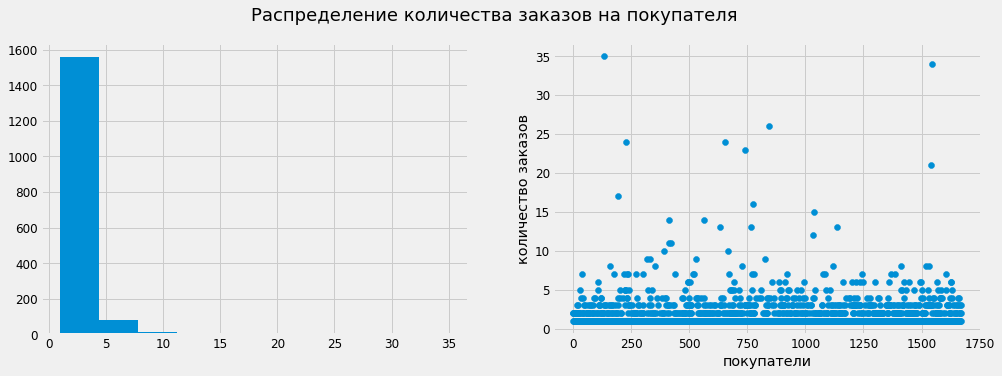

Дополнительные показатели:
95-й перцентиль - 5;
99-й перцентиль - 11.

Критерий Шапиро-Уилка: p-value - 0.0000%; statistic - 42.8067%.
Распределение не нормально.


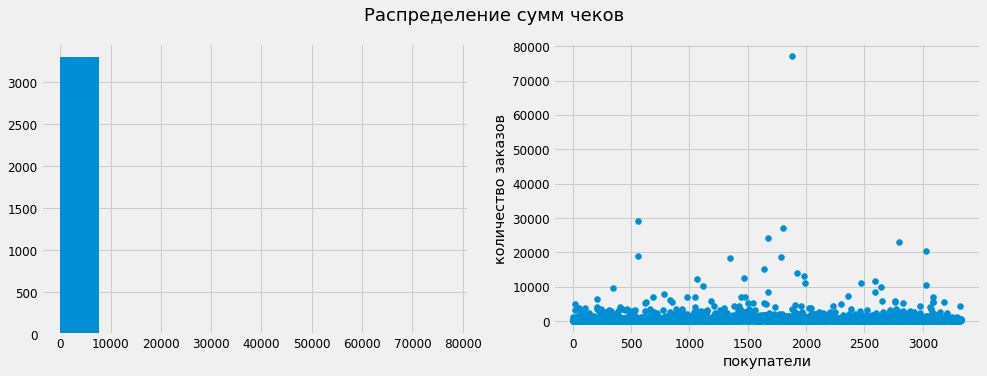

Дополнительные показатели:
95-й перцентиль - 2036;
99-й перцентиль - 5940.

Критерий Шапиро-Уилка: p-value - 0.0000%; statistic - 20.9830%.
Распределение не нормально.


In [18]:
distr('Распределение количества заказов на покупателя', rep_cus['purchaseid'], rep_cus)
distr('Распределение сумм чеков', rep_rev['revenue'], rep_rev)

Таким образом, статистическими выбросами определено количество чеков - 11 чеков, сумма чека - 5940 руб. и выше.

### 3.4 Обработка статистических выбросов и формирование итогового набора данных <a class="anchor" id="3.4-bullet"></a>

Для устранения влияния на показатели данные будут очищены от статистических выбросов в соответствии с параметрами определёнными в предыдущем разделе.

In [19]:
# формирование списка иденификаторов покупателей с количеством чеков 11 и более
list_11 = list(rep_cus[rep_cus['purchaseid'] >= 11]['customerid'])


In [20]:
# удаление выбросов и формирование итогового набора данных
rep = rep.groupby(['purchaseid', 'purchasedate', 'customerid', 'loyalty_program'])\
                 ['revenue'].sum().to_frame().reset_index()
rep = rep[~rep['customerid'].isin(list_11)]
rep = rep[rep['revenue'] < 5940]

Расчёт совокупной выручки с учётом ежемесячной комиссии для участников программы лояльности производится по пессимистическому сценарию, что комиссию с клиента можно списать только при первой покупке в текущем месяце. Для расчёта будет опредлён первый чек каждого месяца и к нему суммирована комиссия за данный месяц.

In [21]:
# выделение месяца чека для признака для последующей группировки
rep['fee_month'] = rep['purchasedate'].dt.month

# группировка для определения минимального номера чека для каждого участника программы лояльности
fir_pur = rep.query('loyalty_program == 1')\
          .groupby(['customerid', 'fee_month'])['purchaseid'].min()\
          .to_frame().reset_index()

fir_pur.head(3)

,customerid,fee_month,purchaseid
0,22005,1,540516
1,22006,1,542503
2,22011,2,543359


In [22]:
# привязка чека к сумме комиссии
fir_pur['month_fee'] = 200
fir_pur = fir_pur[['purchaseid', 'month_fee']]
fir_pur.head(3)

,purchaseid,month_fee
0,540516,200
1,542503,200
2,543359,200


In [23]:
# связывание набора данных и расчётной суммы комиссии по номеру чека
rep = rep.merge(fir_pur, on='purchaseid', how='left')

In [27]:
rep[rep.loyalty_program > 0].purchaseid.nunique() == len(rep[rep.loyalty_program > 0].purchaseid)

True

In [24]:
# расчёт выручки с учётом ежемесячной комиссии
rep = rep.fillna(0)
rep['revenue'] = rep['revenue'] + rep['month_fee']

Параметры итогового набора данных

In [25]:
intro_df(rep)

Параметры таблицы , (строк, полей): (2963, 7)
Количество дубликатов: 0


,purchaseid,purchasedate,customerid,loyalty_program,revenue,fee_month,month_fee
values_counts,2963,81,1647,2,2938,4,2
dtypes,int64,datetime64[ns],int64,int64,float64,int64,float64
isnull_counts,0,0,0,0,0,0,0
max,545218,2017-03-01 00:00:00,23962,1,5908.69,12,200
min,536367,2016-12-01 00:00:00,18026,0,0.95,1,0


Первые 3 строки таблицы:


,purchaseid,purchasedate,customerid,loyalty_program,revenue,fee_month,month_fee
0,536367,2016-12-01,18726,0,295.58875,12,0.0
1,536368,2016-12-01,18726,0,84.47000,12,0.0
2,536369,2016-12-01,18726,0,16.60000,12,0.0


## 4. Анализ программы лояльности<a class="anchor" id="4-bullet"></a>

### 4.1 Оценка выручки по группам клиентов<a class="anchor" id="4.1-bullet"></a>

In [26]:
AB = rep.groupby('loyalty_program').agg({'customerid':'nunique'})
AB

,customerid
loyalty_program,
0,1090
1,557


In [27]:
print('Количество списаний комиссии за анализируемый период - ', rep['month_fee'].count())
print('Сумма списанной комиссии за анализируемый период - {} руб.'.format(rep['month_fee'].sum()))

Количество списаний комиссии за анализируемый период -  2963
Сумма списанной комиссии за анализируемый период - 159400.0 руб.


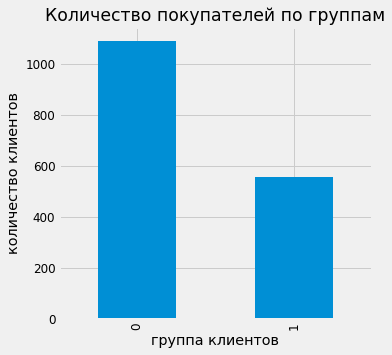

In [28]:
# распределение покупателей по группам
rep.groupby('loyalty_program').agg({'customerid':'nunique'}).plot(
            figsize = (5,5), kind='bar', legend=False)
plt.title('Количество покупателей по группам')
plt.xlabel('группа клиентов')
plt.ylabel('количество клиентов')

plt.savefig('ch1.png', bbox_inches='tight')
plt.show()

В очищенном для анализа наборе данных количество участников программы лояльности составило 1040 клиентов, группа остальных - 1923 клиента.

In [29]:
# создание вспомогательного массива уникальных значений дат и групп
grs = rep[['purchasedate','loyalty_program']].drop_duplicates()

In [30]:
# агрегирование кумулятивных данных по выручке относительно дат проведения теста
rev_agg = grs.apply(
                    lambda x: rep[np.logical_and(rep['purchasedate'] <= x['purchasedate'],
                              rep['loyalty_program'] == x['loyalty_program'])]
                             .agg(
                             {'purchasedate': 'max', 
                             'loyalty_program': 'max', 
                             'purchaseid': pd.Series.nunique, 
                             'customerid':pd.Series.nunique,
                             'revenue': 'sum'}
                    )
                     , axis = 1)\
            .sort_values(by = ['purchasedate', 'loyalty_program'])

rev_agg.head(3)

,purchasedate,loyalty_program,purchaseid,customerid,revenue
0,2016-12-01,0,24,21,11453.577353
8,2016-12-01,1,7,7,6140.318083
33,2016-12-02,0,81,73,42326.021071


In [31]:
rev_agg_A = rev_agg[rev_agg['loyalty_program'] == 0]
rev_agg_A['rev_one'] = rev_agg_A['revenue']/int(AB[AB.index == 0]['customerid'])
rev_agg_A

rev_agg_B = rev_agg[rev_agg['loyalty_program'] == 1]
rev_agg_B['rev_one'] = rev_agg_B['revenue']/int(AB[AB.index == 1]['customerid'])
rev_agg_B.head(3)

,purchasedate,loyalty_program,purchaseid,customerid,revenue,rev_one
8,2016-12-01,1,7,7,6140.318083,11.023910
31,2016-12-02,1,42,38,22328.077020,40.086314
123,2016-12-03,1,78,70,43233.885446,77.619184


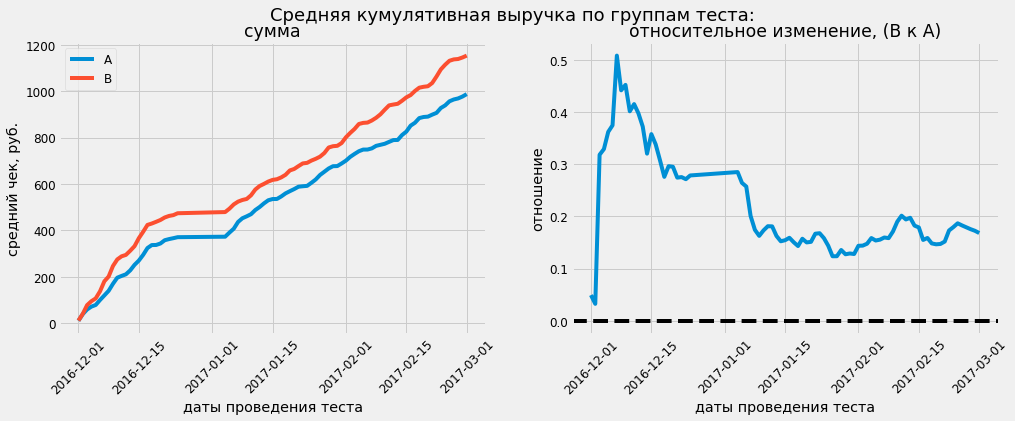

In [32]:
# определение параметров фигуры для вывода двух графиков в одной строке
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Средняя кумулятивная выручка по группам теста:', fontsize=18)

# построение графика кум-ой выручки для группы А
ax[0].plot(rev_agg_A['purchasedate'], rev_agg_A['rev_one'], label = 'A')

# построение графика кум-ой выручки для группы B
ax[0].plot(rev_agg_B['purchasedate'], rev_agg_B['rev_one'], label = 'B')
ax[0].set_title('сумма')
ax[0].set_xlabel('даты проведения теста')
ax[0].set_ylabel('средний чек, руб.')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)

# построение графика относительного отличия средней выручки

# подготовка данных, объединение данных по обеим группам
rev_agg_AB_2 = rev_agg_A.merge(
                             rev_agg_B, 
                             left_on = 'purchasedate', 
                             right_on = 'purchasedate', 
                             suffixes = ['A', 'B']
                             )

# построение графика с маркерной горизонтальной осью
ax[1].plot(
         rev_agg_AB_2['purchasedate'],
         (rev_agg_AB_2['rev_oneB']  / rev_agg_AB_2['rev_oneA']  - 1))
          

ax[1].axhline(y=0, color='black', linestyle='--')

ax[1].set_title('относительное изменение, (B к A)')
ax[1].set_xlabel('даты проведения теста')
ax[1].set_ylabel('отношение')
ax[1].tick_params(axis='x', rotation=45)

plt.savefig('ch2.png', bbox_inches='tight')
plt.show()

Выручка группы участников программы лояльности в расчёте на покупателя на конец анализируемого периода больше на 18
% или 180 руб. При этом наблюдается стабилизация относительной разницы на данне уровне после снижения с 50% пика декабря.

### 4.2 Оценка среднего чека по группам клиентов<a class="anchor" id="4.2-bullet"></a>

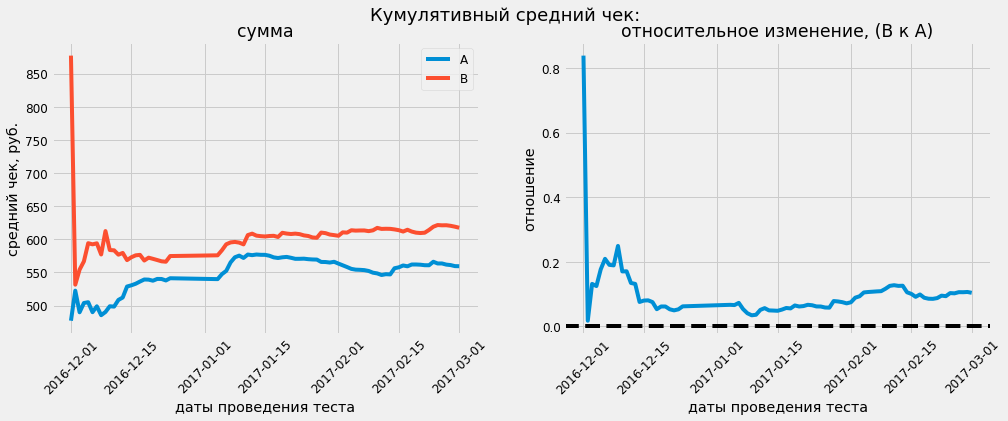

In [33]:
# определение параметров фигуры для вывода двух графиков в одной строке
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Кумулятивный средний чек:', fontsize=18)

# построение графиков средних чеков по группам. Величина чека определяется как подневное
# отношение выручки к количеству чеков.
ax[0].plot(rev_agg_A['purchasedate'], 
           rev_agg_A['revenue'] / rev_agg_A['purchaseid'],
           label = 'A')
ax[0].plot(rev_agg_B['purchasedate'], 
           rev_agg_B['revenue'] / rev_agg_B['purchaseid'], 
           label = 'B')

ax[0].set_title('сумма')
ax[0].set_xlabel('даты проведения теста')
ax[0].set_ylabel('средний чек, руб.')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)


# построение графика относительного отличия среднего чека

# подготовка данных, объединение данных по обеим группам
rev_agg_AB = rev_agg_A.merge(
                             rev_agg_B, 
                             left_on = 'purchasedate', 
                             right_on = 'purchasedate', 
                             suffixes = ['A', 'B']
                             )

# построение графика с маркерной горизонтальной осью
ax[1].plot(
         rev_agg_AB['purchasedate'],
         (rev_agg_AB['revenueB'] / rev_agg_AB['purchaseidB']) / 
         (rev_agg_AB['revenueA'] / rev_agg_AB['purchaseidA']) - 1
          )

ax[1].axhline(y=0, color='black', linestyle='--')

ax[1].set_title('относительное изменение, (B к A)')
ax[1].set_xlabel('даты проведения теста')
ax[1].set_ylabel('отношение')
ax[1].tick_params(axis='x', rotation=45)
plt.savefig('ch3.png', bbox_inches='tight')
plt.show()

Средний чек участников программы лояльности выше на 10% или 50 руб.

### 4.3 Оценка количества покупок по группам клиентов<a class="anchor" id="4.3-bullet"></a>

In [34]:
# агрегирование кумулятивных данных по кол-ву чеков относительно дат проведения теста
pur_agg = grs.apply(
                    lambda x: rep[np.logical_and(rep['purchasedate'] <= x['purchasedate'],
                              rep['loyalty_program'] == x['loyalty_program'])]
                             .agg(
                             {'purchasedate': 'max', 
                             'loyalty_program': 'max',
                              'customerid': 'count',
                             'purchaseid':'count'}
                    )
                     , axis = 1)\
            .sort_values(by = ['purchasedate', 'loyalty_program'])

# разделение данных о количестве чеков по группам покупателей
pur_agg_A = rev_agg[rev_agg['loyalty_program'] == 0]
pur_agg_B = rev_agg[rev_agg['loyalty_program'] == 1]

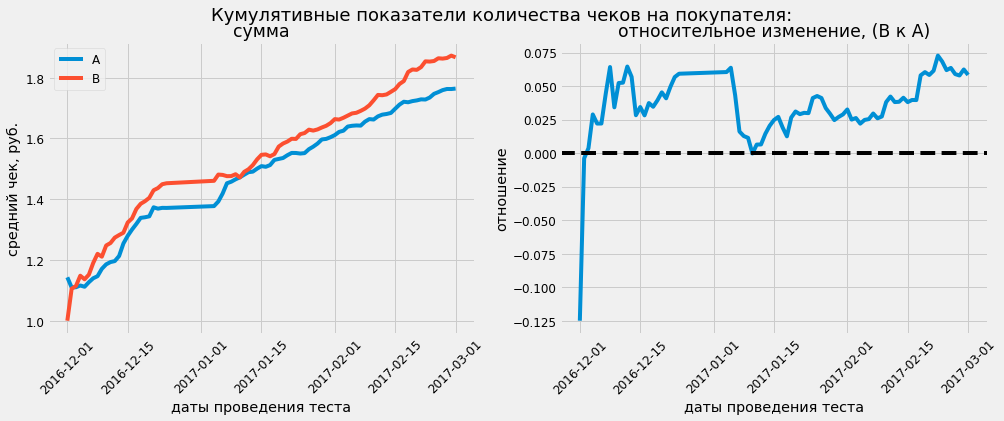

In [35]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Кумулятивные показатели количества чеков на покупателя:', fontsize=18)

# построение графиков средних чеков по группам. Величина чека определяется как подневное
# отношение выручки к количеству чеков.
ax[0].plot(pur_agg_A['purchasedate'], 
           pur_agg_A['purchaseid']/pur_agg_A['customerid'],
           label = 'A')
ax[0].plot(pur_agg_B['purchasedate'], 
           pur_agg_B['purchaseid']/pur_agg_B['customerid'], 
           label = 'B')

ax[0].set_title('сумма')
ax[0].set_xlabel('даты проведения теста')
ax[0].set_ylabel('средний чек, руб.')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)

# построение графика относительного отличия количества чеков

# подготовка данных, объединение данных по обеим группам
pur_agg_AB = pur_agg_A.merge(
                             pur_agg_B, 
                             left_on = 'purchasedate', 
                             right_on = 'purchasedate', 
                             suffixes = ['A', 'B']
                             )

# построение графика с маркерной горизонтальной осью
ax[1].plot(
         pur_agg_AB['purchasedate'],
         (pur_agg_AB['purchaseidB'] / pur_agg_AB['customeridB']) / 
         (pur_agg_AB['purchaseidA'] / pur_agg_AB['customeridA']) - 1
          )

ax[1].axhline(y=0, color='black', linestyle='--')

ax[1].set_title('относительное изменение, (B к A)')
ax[1].set_xlabel('даты проведения теста')
ax[1].set_ylabel('отношение')
ax[1].tick_params(axis='x', rotation=45)
plt.savefig('ch4.png', bbox_inches='tight')
plt.show()

Количество покупок каждого клиента сопоставимо растёт для каждой группы и находится на уровне 1.8 покупки, однако участники программы лояльности на конец анализируемого периода покупают немного больше - на 6%.

### 4.4 Расчёт показателей статистической значимости и проверка гипотез<a class="anchor" id="4.4-bullet"></a>

Проверке подлежат двухсторонние гипотезы для двух групп клиентов:

- группа А - клиенты, не участвующие в программе лояльности,
- группа В - клиенты -участники программы лояльности.

#### 4.4.1 Средний чек<a class="anchor" id="4.4.2-bullet"></a>

Гипотезы к проверке

H0: Статистически значимые отличия в среднем чеке групп А и В отсутствуют.

Н1: Есть статистически значимые отличия в среднем чеке групп А и В.

In [36]:
# исходные данные для проверки
rep.head(3)

,purchaseid,purchasedate,customerid,loyalty_program,revenue,fee_month,month_fee
0,536367,2016-12-01,18726,0,295.58875,12,0.0
1,536368,2016-12-01,18726,0,84.47000,12,0.0
2,536369,2016-12-01,18726,0,16.60000,12,0.0


In [37]:
# применение критерия Манна-Уитни для среднего чека

print('Оценка статистической значимости отличия по среднему чеку')
print()
print('Критерий Манна-Уитни для среднего чека: {0:.3f}.'.format\
    (stats.mannwhitneyu
    (rep[rep['loyalty_program'] == 0]['revenue'], 
     rep[rep['loyalty_program'] == 1]['revenue'])
    [1]))

# расчёт относительного отличия в среднем чеке
print('Относительное отличие вмежду группами: {:.0%}.'.format\
                        (rep[rep['loyalty_program'] == 0]['revenue'].mean() /
                        rep[rep['loyalty_program'] == 1]['revenue'].mean() - 1))

Оценка статистической значимости отличия по среднему чеку

Критерий Манна-Уитни для среднего чека: 0.000.
Относительное отличие вмежду группами: -9%.


Таким образом, нулевая гипотеза об отсутствии статистически значимых отличий в среднем чеке отвергается и подтверждается среднее за анализируемый период преимущество группы участников программы лояльности в 9%.

#### 4.4.2 Количество покупок<a class="anchor" id="4.4.3-bullet"></a>

Гипотезы к проверке

H0: Статистически значимые отличия в среднем количестве покупок групп А и В отсутствуют.

Н1: Есть статистически значимые отличия в среднем количестве покупок групп А и В.

In [38]:
# применение критерия Манна-Уитни для среднего количества покупок
print('Оценка статистической значимости отличия в среднем количестве покупок')
print()
print('Критерий Манна-Уитни для среднего количества покупок: {0:.3f}.'.format\
    (stats.mannwhitneyu
    (pur_agg[pur_agg['loyalty_program'] == 0]['purchaseid'], 
     pur_agg[pur_agg['loyalty_program'] == 1]['purchaseid'])
    [1]))

# расчёт относительного отличия для среднего количества покупок
print('Относительное отличие между группами: {:.0%}.'.format\
                        ((pur_agg_AB['purchaseidA'] / pur_agg_AB['customeridA']).mean() / 
                        (pur_agg_AB['purchaseidB'] / pur_agg_AB['customeridB']).mean() - 1))

Оценка статистической значимости отличия в среднем количестве покупок

Критерий Манна-Уитни для среднего количества покупок: 0.000.
Относительное отличие между группами: -3%.


Таким образом, нулевая гипотеза об отсутствии статистически значимых отличий в среднем количестве покупок отвергается и фиксируется среднее за анализируемый период преимущество группы участников программы лояльности на 3%.

### 4.5 TOP-5 товаров каждой клиентской группы<a class="anchor" id="4.5-bullet"></a>

Для определения причин отличий между группами проводится анализ покупательских предпочтений каждой группы. С этой целью выделяется по выручке TOP-5 товаров каждого из анализируемых месяцев и отражается на сводном графике.

In [39]:
# выделение месяца анализа
rep_st['month'] = rep_st['purchasedate'].dt.month_name()

In [40]:
# выделение групп товаров и расчёт выручки по группам клиентов
ite_A = rep_st[rep_st['loyalty_program'] == 0]\
                .groupby(['month', 'item_id', 'loyalty_program'])['revenue']\
                .sum().to_frame().reset_index()

ite_B = rep_st[rep_st['loyalty_program'] == 1]\
                .groupby(['month', 'item_id', 'loyalty_program'])['revenue']\
                .sum().to_frame().reset_index()

# формирование помесячного рэнкинга
ite_A['r'] = ite_A.groupby(['month'])['revenue'].rank(ascending=False)
ite_B['r'] = ite_B.groupby(['month'])['revenue'].rank(ascending=False)

# выделение TOP-5 товаров помесячно и удаление одного дня марта
ite_A = ite_A.query('r <= 5 & month != "March"')
ite_B = ite_B.query('r <= 5 & month != "March"')

# формирование сводных данных для удобства визуализации
ite_AB = pd.concat([ite_A, ite_B]).sort_values(by='revenue', ascending=False)

# объединение выручки одинаковых товаров из разных месячных выборок
ite_AB = ite_AB.groupby(['item_id', 'loyalty_program'])\
                        .agg({'revenue':'sum'}).reset_index()\
                        .sort_values(by='revenue', ascending=False)
ite_AB.head(3)

,item_id,loyalty_program,revenue
11,23166,0,77182.560000
20,M,1,43901.506271
6,22423,0,35486.395000


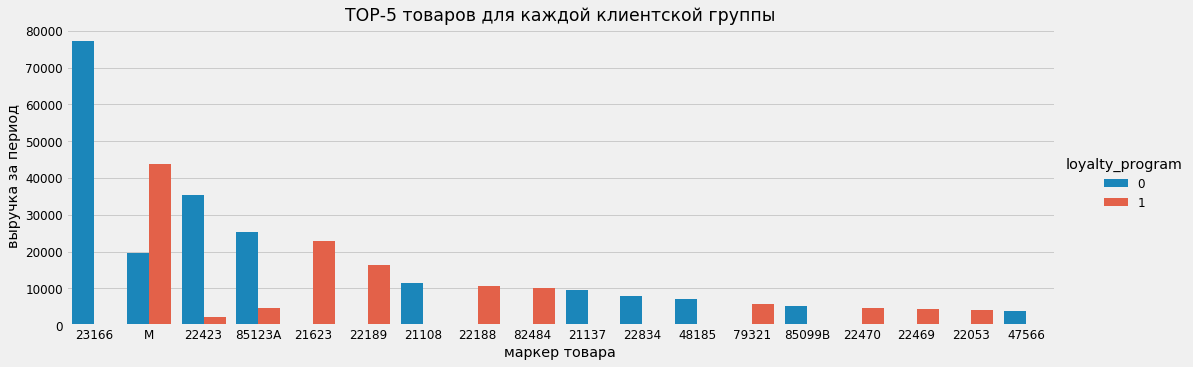

In [41]:
# построение графика 
sns.catplot(x='item_id', y='revenue', hue='loyalty_program',
            data=ite_AB, kind='bar', height=5, aspect=3, ci=None)
plt.title('ТОР-5 товаров для каждой клиентской группы')
plt.xlabel('маркер товара')
plt.ylabel('выручка за период')
plt.savefig('ch5.png', bbox_inches='tight')
plt.show()

Таким образом, товарные предпочтения клиентских групп являются разными. Имеющиеся пересечения по товарам "М", "22423", "85123A" имеют ярко выраженный долевой дисбаланс и находятся в рамках общей картины.

### 4.6 Распределение выручки между  магазинами <a class="anchor" id="4.6-bullet"></a>

In [42]:
# группировка данных по выручке в разрезе магазинов и групп клиентов

sho = rep_st.groupby(['shopid', 'loyalty_program'])['revenue']\
            .sum().to_frame().reset_index()

# оценка долей выручки по магазинам

sho['%'] = round((sho['revenue']/(sho['revenue'].sum())*100),1)
sho = sho.sort_values(by='%', ascending=False)
sho.head()

,shopid,loyalty_program,revenue,%
0,Shop 0,0,1.205340e+06,52.9
1,Shop 0,1,6.403606e+05,28.1
23,Shop 3,0,1.040972e+05,4.6
27,Shop 6,0,5.862250e+04,2.6
25,Shop 4,0,5.485476e+04,2.4


Большая часть выручки обоих групп формируется в магазиние "Shop 0": для участников программы - 28%, для остальных клиентов - 53%.

In [43]:
# из-за превалирования Shop 0 выделяются две группы данных для отдельной визуализации

sho_oth = sho[sho['shopid'] != 'Shop 0']
sho_0 = sho[sho['shopid'] == 'Shop 0']

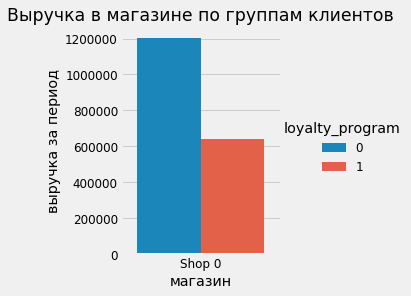

In [44]:
# построение графика выручки для Shop0

sns.catplot(x='shopid', y='revenue', hue='loyalty_program',
            data=sho_0, kind='bar', height=4, aspect=1, ci=None)
plt.title('Выручка в магазине по группам клиентов')
plt.xlabel('магазин')
plt.ylabel('выручка за период')
plt.savefig('ch6.png', bbox_inches='tight')
plt.show()

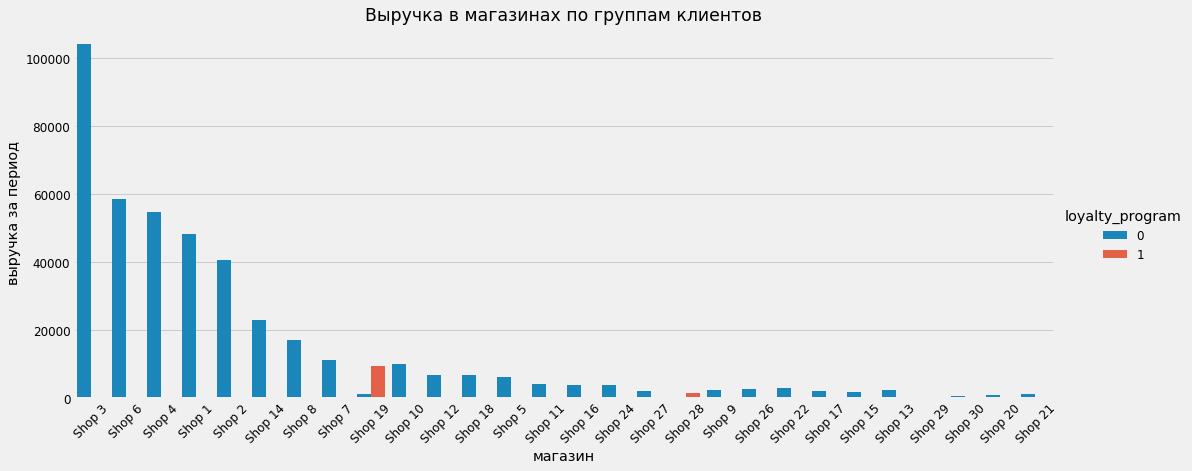

In [45]:
# построение графика выручки для остальных магазинов

sns.catplot(x='shopid', y='revenue', hue='loyalty_program',
            data=sho_oth, kind='bar', height=6, aspect=2.5, ci=None)
plt.title('Выручка в магазинах по группам клиентов')
plt.xlabel('магазин')
plt.ylabel('выручка за период')
plt.xticks(rotation=45)
plt.savefig('ch7.png', bbox_inches='tight')
plt.show()

Таким образом, остальные магазины сети практически не задействованы в программе лояльности. Из общего ряда выделяются только Shop 19 и Shop 28, где подавляюще большая часть выручки формируется участниками программы лояльности.

## 5. Выводы и рекомендации<a class="anchor" id="5-bullet"></a>

*Выводы*

При первичной обработке данных были выявленны аномалии:

- информация о датах представлена типом данных 'object';
- в количестве покупок имеются нулевые и отрицательные значения;
- имеются 36210 пропущенных значений id покупателя;
- количество значений id товара меньше, чем количество строк, т.е. одинаковые товары занесены в БД с разными ценами.

После удаления выбивающихся из логики исследования данных можно выделить следующие особенности очищенного датасета:

- количество строк уменьшилось на 49%, с 105 тыс. до 54 тыс. строк;
- количество чеков уменьшилось на 32%, с 4,9 тыс. до 3,3 тыс. чеков;
- количество уникальных покупателей на 6%, с 1,7 тыс. до 1,6 тыс. покупателей.

После анализа статистическими выбросами определено:
 - количество чеков - 11 чеков,
 - сумма чека - 5940 руб. и выше.
 
В очищенном для анализа наборе данных количество участников программы лояльности составило 557 клиентов, группа остальных - 1090 клиента.
 
Выявлено, что средний чек участников программы лояльности на конец анализируемого периода выше на 10% или на 9% в среднем за период и эта преимущество сохранялось на протяжении всего анализируемого периода.
 
Количество покупок каждого клиента сопоставимо растёт для каждой группы и находится на уровне 1.8 покупки, однако участники программы лояльности покупают на конец анализируемого немного больше - на 6% или в среднем на 3% за весь период.
 
Статистически значимые отличия в метриках потверждены статистически критерием Манна-Уитни .
 
Товарные предпочтения клиентских групп являются разными. Имеющиеся пересечения по товарам "М", "22423", "85123A" имеют ярко выраженный долевой дисбаланс и находятся в рамках общей картины.
 
Большинство магазинов сети практически не задействованы в программе лояльности. Из общего ряда выделяются только Shop 19 и Shop 28, где подавляюще большая часть выручки формируется участниками программы лояльности.
 

*Рекомендации*

Признать программу лояльности соответствующей бизнес-задачам и провести мероприятия по развитию выявленных зон роста.

С учётом выявленных особенностей предлагается изменить условия программы для включения в её периметр всех видов товаров, провести дополнительное изучение причин слабой покупательской активности участников программмы во всех магазинах сети, после изменений условий программы провести информационное воздействие на клиентов.
